Importing Important Libraries

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

Mounting Google Drive for Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Preprocessing

In [3]:
sms = pd.read_csv('/content/drive/MyDrive/spam.csv', encoding='ISO-8859-1')
sms.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)
encoder = LabelEncoder()
sms['target'] = encoder.fit_transform(sms['target'])

In [4]:
sms.drop_duplicates(keep='first', inplace=True) #Dropping Duplicate Values

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
sms['num_of_characters'] = sms['text'].apply(len)
sms['num_of_words'] = sms['text'].apply(lambda x: len(nltk.word_tokenize(x)))
sms['num_of_sentences'] = sms['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

Exploratory data analysis and data visualization


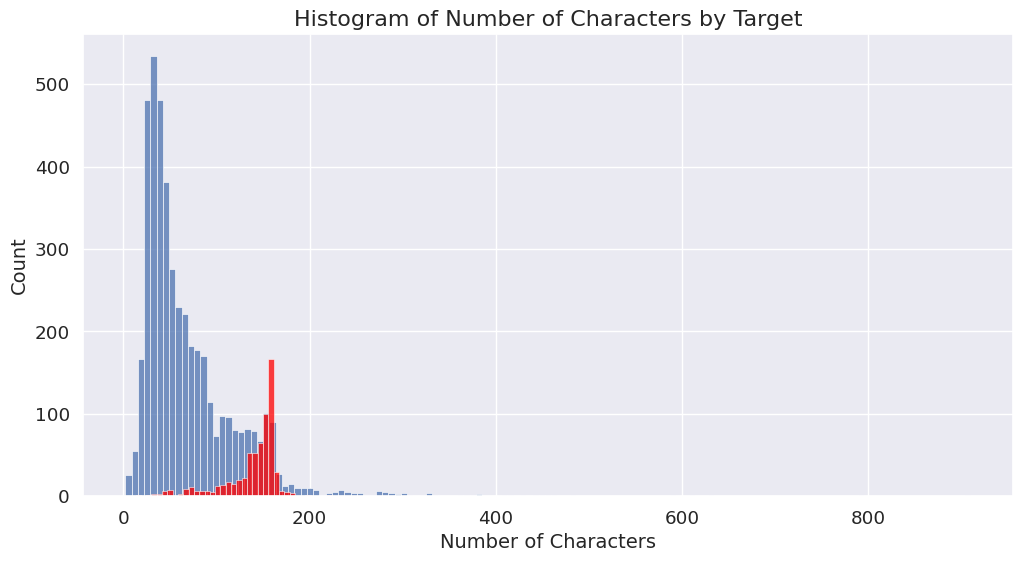

In [8]:

sns.set(font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.histplot(sms[sms['target'] == 0]['num_of_characters'])
sns.histplot(sms[sms['target'] == 1]['num_of_characters'], color='red')
plt.xlabel('Number of Characters', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Histogram of Number of Characters by Target', fontsize=16)
plt.show()



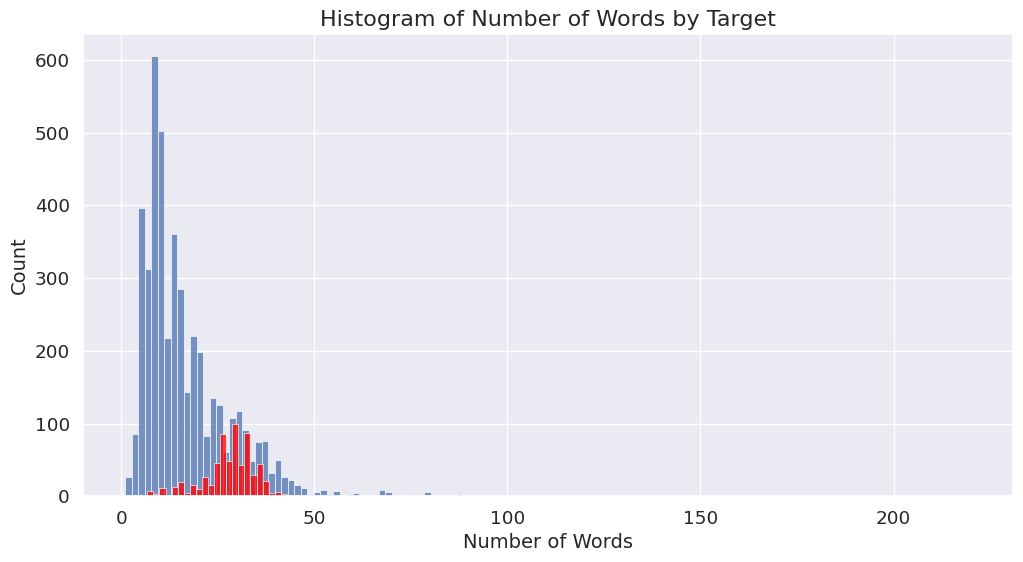

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(sms[sms['target'] == 0]['num_of_words'])
sns.histplot(sms[sms['target'] == 1]['num_of_words'], color='red')
plt.xlabel('Number of Words', fontsize=14)  # Set the font size for x-axis label
plt.ylabel('Count', fontsize=14)  # Set the font size for y-axis label
plt.title('Histogram of Number of Words by Target', fontsize=16)  # Set the font size for title
plt.show()

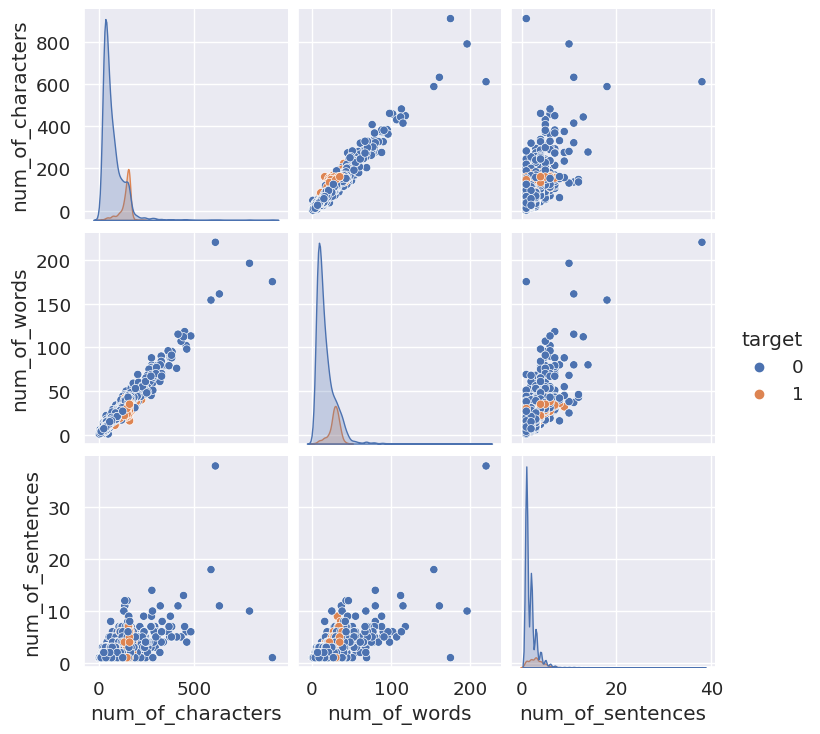

In [10]:
sns.pairplot(sms, hue='target')
plt.show()

<ipython-input-11-90cdc84a09e6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(sms.corr(), annot=True)


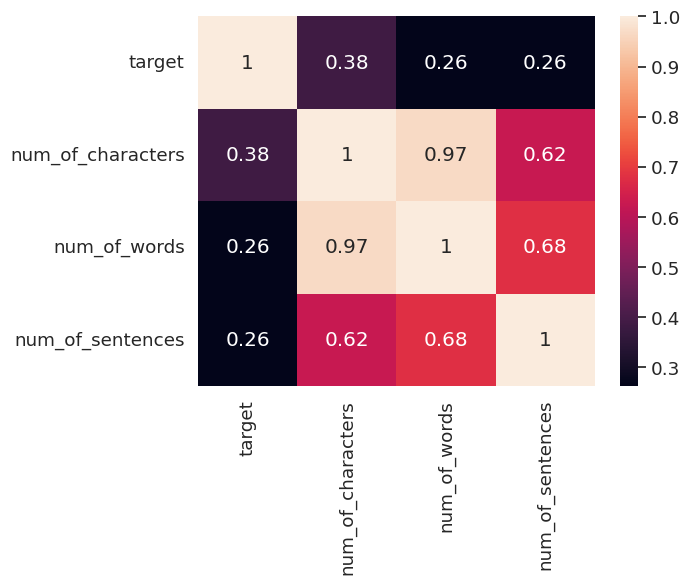

In [11]:
sns.heatmap(sms.corr(), annot=True)
plt.show()

Text Preprocessing and Feature engineering

In [12]:

nltk.download('stopwords')
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))

    return " ".join(y)

sms['transformed_text'] = sms['text'].apply(transform_text)

 Wordcloud visualization

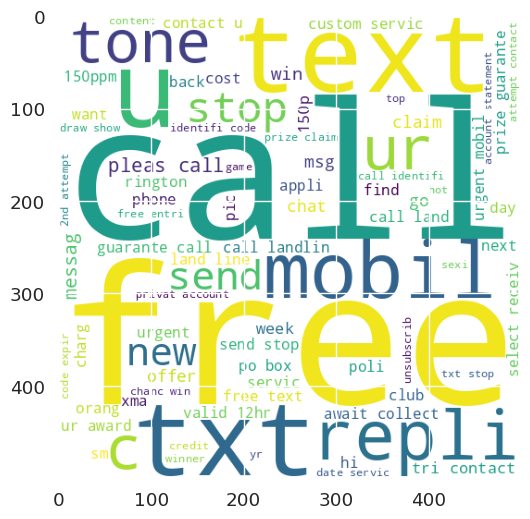

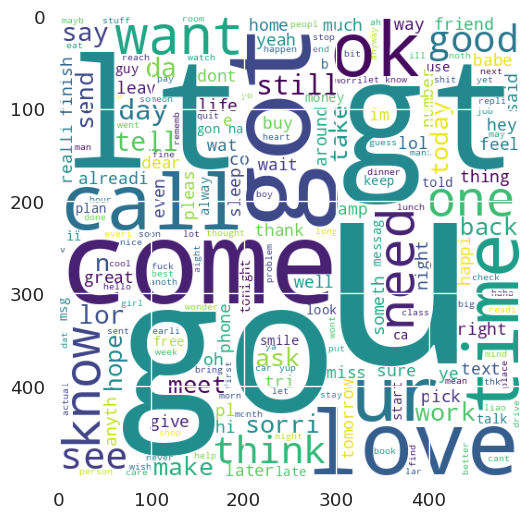

In [14]:

wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

spam_wc = wc.generate(sms[sms['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15, 6))
plt.imshow(spam_wc)
plt.show()

ham_wc = wc.generate(sms[sms['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.figure(figsize=(15, 6))
plt.imshow(ham_wc)
plt.show()

Tokenization

In [15]:

tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(sms['transformed_text']).toarray()
y = sms['target'].values

Data Splitting for training

In [16]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

**Naive Bayes**

In [19]:
# Train a Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

In [20]:
# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))

Accuracy: 0.8694390715667312
Confusion Matrix:
 [[788 108]
 [ 27 111]]
Precision: 0.5068493150684932


**Support Vector Machine**

In [21]:
svc = SVC(kernel='sigmoid', gamma=1.0)
bc = BaggingClassifier(n_estimators=50, random_state=2)

In [22]:
# Train and evaluate classifiers
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    return accuracy, precision

In [23]:
accuracy_svc, precision_svc = train_classifier(svc, X_train, y_train, X_test, y_test)

Bagging Classifier

In [24]:
accuracy_bc, precision_bc = train_classifier(bc, X_train, y_train, X_test, y_test)

In [25]:
results_df = pd.DataFrame({'Classifier': ['Gaussian Naive Bayes', 'Support Vector Machine', 'Bagging Classifier'],
                            'Accuracy': [accuracy_score(y_test, y_pred), accuracy_svc, accuracy_bc],
                            'Precision': [precision_score(y_test, y_pred), precision_svc, precision_bc]})

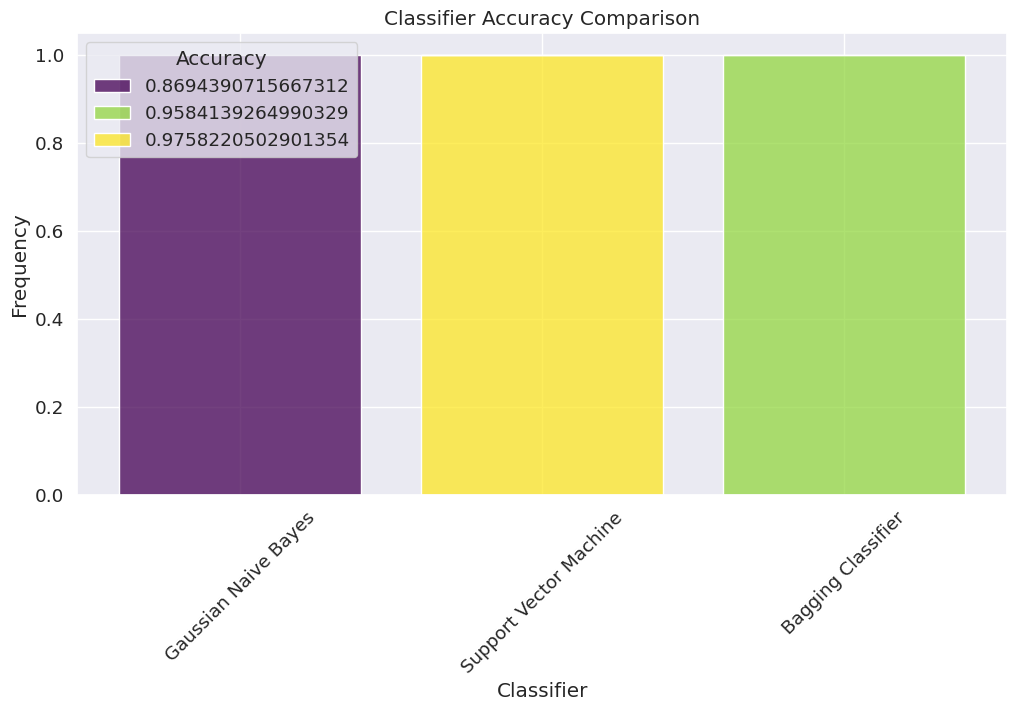

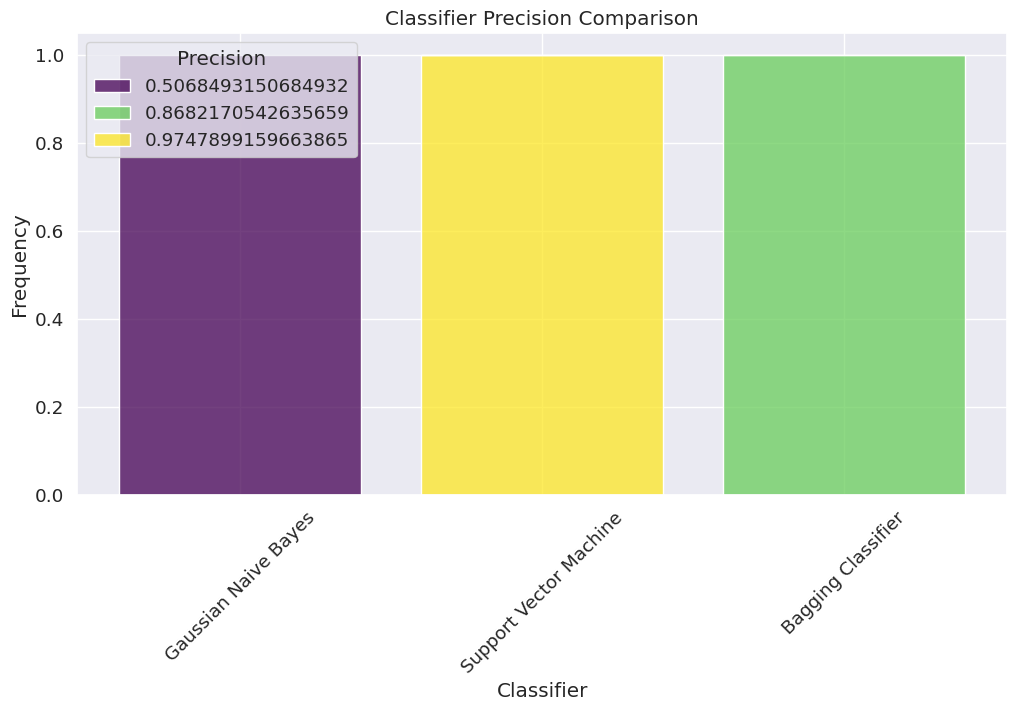

In [26]:
# Plot the results
plt.figure(figsize=(12, 6))
sns.histplot(data=results_df, x='Classifier', hue='Accuracy', multiple='stack', shrink=0.8, binwidth=0.1, palette='viridis')
plt.title('Classifier Accuracy Comparison')
plt.xticks(rotation=45)
plt.xlabel('Classifier')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=results_df, x='Classifier', hue='Precision', multiple='stack', shrink=0.8, binwidth=0.1, palette='viridis')
plt.title('Classifier Precision Comparison')
plt.xticks(rotation=45)
plt.ylabel('Classifier')
plt.ylabel('Frequency')
plt.show()